In [ ]:
! pip install densratio

In [10]:
# TODO

# 1.
# Make non-linear in such a way that you cannot extrapolate to unseen P(Y,X)

# 2. 
# Use importance estimation to extrapolate.

# 3. 
# Use interactive latent variable to make extrapolation fail even with importance estimation. 

# 4
# Make true model such that excluding variables should recover a model that is "robust" (P(X|H))

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

In [651]:
def plot_dat(vars_):
    f, axes = plt.subplots(len(vars_), 1, sharex=True, figsize=(20, 10))

    for (H,title),ax in zip(vars_, axes):
        for i,h in zip(['A', 'B', 'C', 'D'], H):
            sns.distplot(h, label = i, ax=ax)
        ax.legend()
        ax.set_title(title)
        
    # plt.title(title)
    # plt.show()

In [708]:
import numpy as np
from scipy.stats import gamma
import seaborn as sns

# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)
def fn(h, v, z, w):
    # val = (np.log(h) + 2.0*h**2 + 0.5*z + 0.2*z**2)**1.5 + np.random.normal(0, 50)
    # val = 1.5*(v > 120)*w*v**2 + 0.5*w*v + 0.2*w*z**2 + np.random.normal(0, 25, size = h.shape[0])
    val = -.5*(h > 25)*w*h**2 + 2.0*w*h + 0.5*w*z**2 + np.random.normal(0, 5, size = h.shape[0])
    # val = (w*0.5 + w*1.5*v + w*0.5*z + w*0.2*z**2) + np.random.normal(0, 25, size = h.shape[0])
    return val/10


def generate_data(N, fn):
    # H is latent variable, distribution changes (not )
    H = [gamma.rvs(a, loc=b, scale=1, size=N) 
         for a,b in [(20, 2), (4, 15), (4, 20),  (2, 25)]]

    # X := f(H, N_X)
    V = [(1/(h))*250 + np.random.gamma(2, 1, size=N) for h in H]

    # Z = [gamma.rvs(int(np.random.normal(40, 10)), loc=0, scale=1, size=N) for h in H]
    # Z := f(N_Z) 
    Z = [gamma.rvs(2, loc=1, scale=3, size=N) for h in H]

    # W := f(N_W) -- TREATMENT
    W = [np.random.binomial(1, 0.5, size=N) for h in H]

    # Y:= fn(H, V, Z, W, N_Y)
    Y = [fn(H[idx], V[idx], Z[idx], W[idx]) for idx in range(4)]

    tau = [fn(h,v,z,1) - fn(h,v,z,0) for h,v,z in zip(H,V,Z)]

    print([np.mean(t) for t in tau])

    plot_dat([(H,'H'), (V, 'V') , (Z, 'Z'), (Y, 'Y'), (tau, 'tau')])

    return [(y, np.array([w,h]).T) for y,v,z,w,h in zip(Y, V, Z, W, H)]

[-1.8319900313442359, 6.8242490329315295, -1.566469827783972, -27.585691920544253]


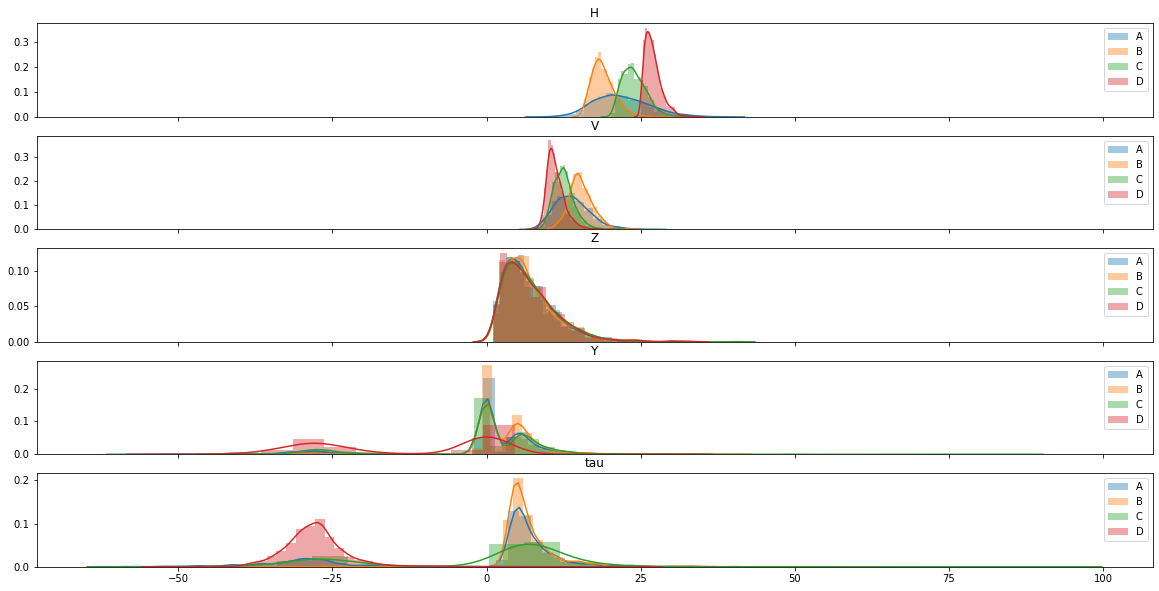

In [709]:
dat = generate_data(1000, fn)

In [710]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import gaussian_kde

def kde_score(X):
    return gaussian_kde(X).evaluate


def run_model(dat, model, phi, train_idx, target_idx, use_weights = True):
    d = [(phi.fit_transform(t[1]), t[1][:, 0], t[0]) for t in dat]
    X_train, X_target = d[train_idx][0], d[target_idx][0]

    if use_weights is True:
        ps, pt = kde_score(X_train[:, 2]), kde_score(X_target[:, 2])
        weights = pt(X_train[:, 2]) / ps(X_train[:, 2])
        # sns.distplot(weights)
    else:
        weights = np.ones(X_train.shape[0])

    model.fit(X_train, d[train_idx][2], sample_weight=weights)

    y0 = [np.mean(model.predict(p[w == 0])) for p,w,y in d]
    y1 = [np.mean(model.predict(p[w == 1])) for p,w,y in d]

    # [model.score(phi.fit_transform(target[1]), target[0]) for target in [A,B,C,D]]

    return [a-b for a,b in zip(y1, y0)]

In [711]:
phi = PolynomialFeatures(degree=2, include_bias=True)

In [814]:
model = RandomForestRegressor(n_estimators=50, max_depth=2, min_samples_leaf=.05)
run_model(dat, model, phi, 0, 3, use_weights = True)

[1.1476186781814126, 9.986926809337449, 0.5513026860865399, -28.73851241681447]

In [815]:
model = RandomForestRegressor(n_estimators=50, max_depth=2, min_samples_leaf=.05)
run_model(dat, model, phi, 0, 3, use_weights = False)

[-2.0177356434099964,
 6.93513114333886,
 -2.8233325574391253,
 -31.751573100098636]

In [818]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 3, use_weights = True)

[-11.621305203691136,
 -2.7389752032266657,
 -17.81685825678888,
 -27.65937514637845]

In [819]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 3, use_weights = False)

[-1.9607399259070992,
 6.848604317433879,
 -7.813145296708506,
 -16.738345104601528]

In [275]:
resids = [model.predict(phi.fit_transform(target[1])) - target[0] for target in [A,B,C,D]]

In [281]:
from scipy.stats import wasserstein_distance

[wasserstein_distance(resids[0], r) for r in resids]

[0.0, 2.4445082278784835, 0.928636981624142, 6.661249552011165]

In [ ]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 

In [ ]:
import seaborn as sns

idx = np.random.choice(B[1].shape[0], size = 1000)

sns.kdeplot(C[1][idx])

In [6]:
from densratio import densratio

In [ ]:
d = densratio(A[1], B[1])

In [522]:
w = d.compute_density_ratio(A[1])

In [7]:
from pykliep.pykliep import DensityRatioEstimator

In [ ]:
kliep = DensityRatioEstimator()

kliep.fit(A[1], C[1])

In [549]:
kliep